<a href="https://colab.research.google.com/github/dbeniteze/autoencoder_convolucional/blob/master/cifar10_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip3 install keras==2.3.1

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 32, 32, 3)).astype('float32')

#X_train_mean = np.mean(X_train, axis=(0,1,2))
#X_train_std = np.std(X_train, axis=(0,1,2))
#X_train = (X_train - X_train_mean) / X_train_std
#X_test = (X_test - X_train_mean) / X_train_std


def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

#X_train = grayscale(X_train)
#X_test = grayscale(X_test)

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255


epoch = 50

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 15:
        lrate = 0.0005
    if epoch > 30:
        lrate = 0.0003
    return lrate


In [0]:
#autoencoder con Conv2DTranspose
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
LF = (5,5)
x = Conv2D(64, kernel_size=LF, activation='elu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(32, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(16, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
encoded =Conv2D(4, kernel_size=LF, activation='elu', padding='same')(x)

#encoded = Model(input_img, encoded)
#encoded.summary()

x = Conv2DTranspose(4, kernel_size=LF, activation='elu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2DTranspose(8, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2DTranspose(16, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2DTranspose(32, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2DTranspose(64, kernel_size=LF, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
decoded = Conv2DTranspose(3, kernel_size=LF, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

In [128]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule(epoch)),  loss='mse', metrics=[coeff_determination])

autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 63s 1ms/step - loss: 0.0249 - coeff_determination: 0.6048 - val_loss: 0.0148 - val_coeff_determination: 0.7649
Epoch 2/50
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0100 - coeff_determination: 0.8412 - val_loss: 0.0065 - val_coeff_determination: 0.8971
Epoch 3/50
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0083 - coeff_determination: 0.8677 - val_loss: 0.0052 - val_coeff_determination: 0.9170
Epoch 4/50
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0076 - coeff_determination: 0.8800 - val_loss: 0.0072 - val_coeff_determination: 0.8862
Epoch 5/50
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0070 - coeff_determination: 0.8888 - val_loss: 0.0042 - val_coeff_determination: 0.9329
Epoch 6/50
50000/50000 [==============================] - 61s 1ms/step - loss: 0.0066 - coeff_determinati

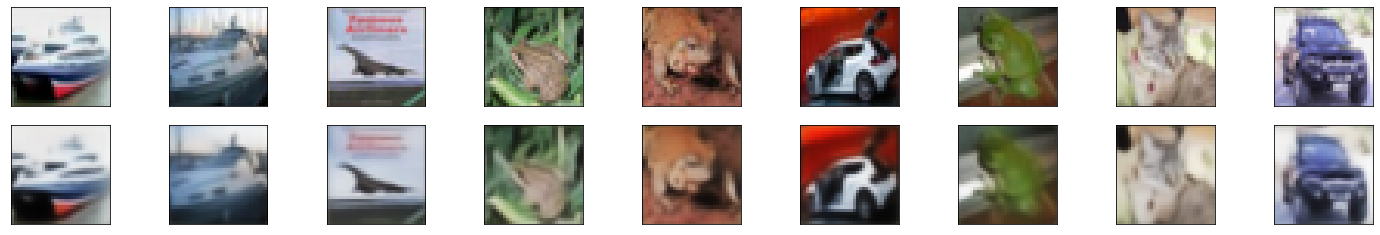

In [131]:
#visualizacion de la decodificacion

decoded_imgs = autoencoder.predict(X_test)

n = 9
plt.figure(figsize=(25, 4))
for i in range(n):
    i = i + 1
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
